In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold
import pickle

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [6]:
from sklearn.model_selection import train_test_split, KFold

In [ ]:
eps = 1e-8
def learn_HAT_sgd(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, eps=1e-8):
    np.random.seed(random_seed)
    if cost_function == 'abs':
        cost = cost_abs
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    
   

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        sum_square_gradients_H+= eps+np.square(del_h)
        sum_square_gradients_A+= eps+np.square(del_a)
        sum_square_gradients_T+= eps+np.square(del_t)
        
        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        
        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T

In [38]:
eps = 1e-8
def learn_HAT_adagrad(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, eps=1e-8):
    np.random.seed(random_seed)
    if cost_function == 'abs':
        cost = cost_abs
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    
    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        sum_square_gradients_H+= eps+np.square(del_h)
        sum_square_gradients_A+= eps+np.square(del_a)
        sum_square_gradients_T+= eps+np.square(del_t)
        
        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        
        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T

In [39]:
H_au_ada, A_au_ada, T_au_ada = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=2000, lr=1, dis=True, cost_function=cost)

493.480876782
67.0766118142
67.0027281218
66.9975590542


In [30]:
H_au, A_au, T_au = learn_HAT(case, au_tensor, a, a, num_iter=4000, lr=0.1, dis=True, cost_function=cost)

499.330182087
112.077018067
70.6621710465
67.1495106266
67.044926746
67.0160376065
67.0038023482
67.0012030543


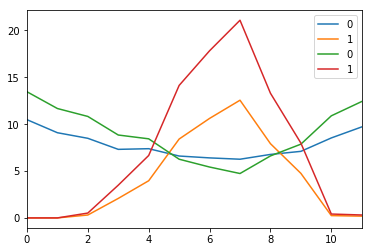

In [35]:
ax = pd.DataFrame(T_au_ada).plot()
pd.DataFrame(T_au).plot(ax=ax)